In [3]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal

### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/preprocess2/input3-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if not os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    ecg_path = '../../cranberry2/Preprocessing/ECG_250Hz/ECG_250Hz/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess2/input3/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                # input의 normalization
                data = ppg_per_NRS[start_idx:end_idx]
                fdata = savitzky_golay(data, 9, 3, deriv=0, rate=1)
                pleth_inp = fdata.reshape(5000,1)
                pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                data = ecg_per_NRS[start_idx:end_idx]
                fdata = savitzky_golay(data, 9, 3, deriv=0, rate=1)
                ecg_inp = fdata.reshape(5000,1)
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    x_val_pacu.append([pleth_inp, ecg_inp])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/7316 ...completed
loading data 2/7316 ...completed
loading data 3/7316 ...completed
loading data 4/7316 ...completed
loading data 5/7316 ...completed
loading data 6/7316 ...completed
loading data 7/7316 ...completed
loading data 8/7316 ...completed
loading data 9/7316 ...completed
loading data 10/7316 ...completed
loading data 11/7316 ...completed
loading data 12/7316 ...completed
loading data 13/7316 ...completed
loading data 14/7316 ...completed
loading data 15/7316 ...completed
loading data 16/7316 ...completed
loading data 17/7316 ...completed
loading data 18/7316 ...completed
loading data 19/7316 ...completed
loading data 20/7316 ...completed
loading data 21/7316 ...completed
loading data 22/7316 ...completed
loading data 23/7316 ...completed
loading data 24/7316 ...completed
loading data 25/7316 ...completed
loading data 26/7316 ...completed
loading data 27/7316 ...completed
loading data 28/7316 ...completed
loading data 29/7316 ...completed
loading data 30/7316 ..

loading data 245/7316 ...completed
loading data 246/7316 ...completed
loading data 247/7316 ...completed
loading data 248/7316 ...completed
loading data 249/7316 ...completed
loading data 250/7316 ...completed
loading data 251/7316 ...completed
loading data 252/7316 ...completed
loading data 253/7316 ...completed
loading data 254/7316 ...completed
loading data 255/7316 ...completed
loading data 256/7316 ...completed
loading data 257/7316 ...completed
loading data 258/7316 ...completed
loading data 259/7316 ...completed
loading data 260/7316 ...completed
loading data 261/7316 ...completed
loading data 262/7316 ...completed
loading data 263/7316 ...completed
loading data 264/7316 ...completed
loading data 265/7316 ...completed
loading data 266/7316 ...completed
loading data 267/7316 ...completed
loading data 268/7316 ...completed
loading data 269/7316 ...completed
loading data 270/7316 ...completed
loading data 271/7316 ...completed
loading data 272/7316 ...completed
loading data 273/731

loading data 480/7316 ...completed
loading data 481/7316 ...completed
loading data 482/7316 ...completed
loading data 483/7316 ...completed
loading data 484/7316 ...completed
loading data 485/7316 ...completed
loading data 486/7316 ...completed
loading data 487/7316 ...completed
loading data 488/7316 ...completed
loading data 489/7316 ...completed
loading data 490/7316 ...completed
loading data 491/7316 ...completed
loading data 492/7316 ...completed
loading data 493/7316 ...completed
loading data 494/7316 ...completed
loading data 495/7316 ...completed
loading data 496/7316 ...completed
loading data 497/7316 ...completed
loading data 498/7316 ...completed
loading data 499/7316 ...completed
loading data 500/7316 ...completed
loading data 501/7316 ...completed
loading data 502/7316 ...completed
loading data 503/7316 ...completed
loading data 504/7316 ...completed
loading data 505/7316 ...completed
loading data 506/7316 ...completed
loading data 507/7316 ...completed
loading data 508/731

loading data 715/7316 ...completed
loading data 716/7316 ...completed
loading data 717/7316 ...completed
loading data 718/7316 ...completed
loading data 719/7316 ...completed
loading data 720/7316 ...completed
loading data 721/7316 ...completed
loading data 722/7316 ...completed
loading data 723/7316 ...completed
loading data 724/7316 ...completed
loading data 725/7316 ...completed
loading data 726/7316 ...completed
loading data 727/7316 ...completed
loading data 728/7316 ...completed
loading data 729/7316 ...completed
loading data 730/7316 ...completed
loading data 731/7316 ...completed
loading data 732/7316 ...completed
loading data 733/7316 ...completed
loading data 734/7316 ...completed
loading data 735/7316 ...completed
loading data 736/7316 ...completed
loading data 737/7316 ...completed
loading data 738/7316 ...completed
loading data 739/7316 ...completed
loading data 740/7316 ...completed
loading data 741/7316 ...completed
loading data 742/7316 ...completed
loading data 743/731

loading data 953/7316 ...completed
loading data 954/7316 ...completed
loading data 955/7316 ...completed
loading data 956/7316 ...completed
loading data 957/7316 ...completed
loading data 958/7316 ...completed
loading data 959/7316 ...completed
loading data 960/7316 ...completed
loading data 961/7316 ...completed
loading data 962/7316 ...completed
loading data 963/7316 ...completed
loading data 964/7316 ...completed
loading data 965/7316 ...completed
loading data 966/7316 ...completed
loading data 967/7316 ...completed
loading data 968/7316 ...completed
loading data 969/7316 ...completed
loading data 970/7316 ...completed
loading data 971/7316 ...completed
loading data 972/7316 ...completed
loading data 973/7316 ...completed
loading data 974/7316 ...completed
loading data 975/7316 ...completed
loading data 976/7316 ...completed
loading data 977/7316 ...completed
loading data 978/7316 ...completed
loading data 979/7316 ...completed
loading data 980/7316 ...completed
loading data 981/731

loading data 1187/7316 ...completed
loading data 1188/7316 ...completed
loading data 1189/7316 ...completed
loading data 1190/7316 ...completed
loading data 1191/7316 ...completed
loading data 1192/7316 ...completed
loading data 1193/7316 ...completed
loading data 1194/7316 ...completed
loading data 1195/7316 ...completed
loading data 1196/7316 ...completed
loading data 1197/7316 ...completed
loading data 1198/7316 ...completed
loading data 1199/7316 ...completed
loading data 1200/7316 ...completed
loading data 1201/7316 ...completed
loading data 1202/7316 ...completed
loading data 1203/7316 ...completed
loading data 1204/7316 ...completed
loading data 1205/7316 ...completed
loading data 1206/7316 ...completed
loading data 1207/7316 ...completed
loading data 1208/7316 ...completed
loading data 1209/7316 ...completed
loading data 1210/7316 ...completed
loading data 1211/7316 ...completed
loading data 1212/7316 ...completed
loading data 1213/7316 ...completed
loading data 1214/7316 ...co

loading data 1416/7316 ...completed
loading data 1417/7316 ...completed
loading data 1418/7316 ...completed
loading data 1419/7316 ...completed
loading data 1420/7316 ...completed
loading data 1421/7316 ...completed
loading data 1422/7316 ...completed
loading data 1423/7316 ...completed
loading data 1424/7316 ...completed
loading data 1425/7316 ...completed
loading data 1426/7316 ...completed
loading data 1427/7316 ...completed
loading data 1428/7316 ...completed
loading data 1429/7316 ...completed
loading data 1430/7316 ...completed
loading data 1431/7316 ...completed
loading data 1432/7316 ...completed
loading data 1433/7316 ...completed
loading data 1434/7316 ...completed
loading data 1435/7316 ...completed
loading data 1436/7316 ...completed
loading data 1437/7316 ...completed
loading data 1438/7316 ...completed
loading data 1439/7316 ...completed
loading data 1440/7316 ...completed
loading data 1441/7316 ...completed
loading data 1442/7316 ...completed
loading data 1443/7316 ...co

loading data 1643/7316 ...completed
loading data 1644/7316 ...completed
loading data 1645/7316 ...completed
loading data 1646/7316 ...completed
loading data 1647/7316 ...completed
loading data 1648/7316 ...completed
loading data 1649/7316 ...completed
loading data 1650/7316 ...completed
loading data 1651/7316 ...completed
loading data 1652/7316 ...completed
loading data 1653/7316 ...completed
loading data 1654/7316 ...completed
loading data 1655/7316 ...completed
loading data 1656/7316 ...completed
loading data 1657/7316 ...completed
loading data 1658/7316 ...completed
loading data 1659/7316 ...completed
loading data 1660/7316 ...completed
loading data 1661/7316 ...completed
loading data 1662/7316 ...completed
loading data 1663/7316 ...completed
loading data 1664/7316 ...completed
loading data 1665/7316 ...completed
loading data 1666/7316 ...completed
loading data 1667/7316 ...completed
loading data 1668/7316 ...completed
loading data 1669/7316 ...completed
loading data 1670/7316 ...co

loading data 1872/7316 ...completed
loading data 1873/7316 ...completed
loading data 1874/7316 ...completed
loading data 1875/7316 ...completed
loading data 1876/7316 ...completed
loading data 1877/7316 ...completed
loading data 1878/7316 ...completed
loading data 1879/7316 ...completed
loading data 1880/7316 ...completed
loading data 1881/7316 ...completed
loading data 1882/7316 ...completed
loading data 1883/7316 ...completed
loading data 1884/7316 ...completed
loading data 1885/7316 ...completed
loading data 1886/7316 ...completed
loading data 1887/7316 ...completed
loading data 1888/7316 ...completed
loading data 1889/7316 ...completed
loading data 1890/7316 ...completed
loading data 1891/7316 ...completed
loading data 1892/7316 ...completed
loading data 1893/7316 ...completed
loading data 1894/7316 ...completed
loading data 1895/7316 ...completed
loading data 1896/7316 ...completed
loading data 1897/7316 ...completed
loading data 1898/7316 ...completed
loading data 1899/7316 ...co

loading data 2102/7316 ...completed
loading data 2103/7316 ...completed
loading data 2104/7316 ...completed
loading data 2105/7316 ...completed
loading data 2106/7316 ...completed
loading data 2107/7316 ...completed
loading data 2108/7316 ...completed
loading data 2109/7316 ...completed
loading data 2110/7316 ...completed
loading data 2111/7316 ...completed
loading data 2112/7316 ...completed
loading data 2113/7316 ...completed
loading data 2114/7316 ...completed
loading data 2115/7316 ...completed
loading data 2116/7316 ...completed
loading data 2117/7316 ...completed
loading data 2118/7316 ...completed
loading data 2119/7316 ...completed
loading data 2120/7316 ...completed
loading data 2121/7316 ...completed
loading data 2122/7316 ...completed
loading data 2123/7316 ...completed
loading data 2124/7316 ...completed
loading data 2125/7316 ...completed
loading data 2126/7316 ...completed
loading data 2127/7316 ...completed
loading data 2128/7316 ...completed
loading data 2129/7316 ...co

loading data 2331/7316 ...completed
loading data 2332/7316 ...completed
loading data 2333/7316 ...completed
loading data 2334/7316 ...completed
loading data 2335/7316 ...completed
loading data 2336/7316 ...completed
loading data 2337/7316 ...completed
loading data 2338/7316 ...completed
loading data 2339/7316 ...completed
loading data 2340/7316 ...completed
loading data 2341/7316 ...completed
loading data 2342/7316 ...completed
loading data 2343/7316 ...completed
loading data 2344/7316 ...completed
loading data 2345/7316 ...completed
loading data 2346/7316 ...completed
loading data 2347/7316 ...completed
loading data 2348/7316 ...completed
loading data 2349/7316 ...completed
loading data 2350/7316 ...completed
loading data 2351/7316 ...completed
loading data 2352/7316 ...completed
loading data 2353/7316 ...completed
loading data 2354/7316 ...completed
loading data 2355/7316 ...completed
loading data 2356/7316 ...completed
loading data 2357/7316 ...completed
loading data 2358/7316 ...co

loading data 2565/7316 ...completed
loading data 2566/7316 ...completed
loading data 2567/7316 ...completed
loading data 2568/7316 ...completed
loading data 2569/7316 ...completed
loading data 2570/7316 ...completed
loading data 2571/7316 ...completed
loading data 2572/7316 ...completed
loading data 2573/7316 ...completed
loading data 2574/7316 ...completed
loading data 2575/7316 ...completed
loading data 2576/7316 ...completed
loading data 2577/7316 ...completed
loading data 2578/7316 ...completed
loading data 2579/7316 ...completed
loading data 2580/7316 ...completed
loading data 2581/7316 ...completed
loading data 2582/7316 ...completed
loading data 2583/7316 ...completed
loading data 2584/7316 ...completed
loading data 2585/7316 ...completed
loading data 2586/7316 ...completed
loading data 2587/7316 ...completed
loading data 2588/7316 ...completed
loading data 2589/7316 ...completed
loading data 2590/7316 ...completed
loading data 2591/7316 ...completed
loading data 2592/7316 ...co

loading data 2793/7316 ...completed
loading data 2794/7316 ...completed
loading data 2795/7316 ...completed
loading data 2796/7316 ...completed
loading data 2797/7316 ...completed
loading data 2798/7316 ...completed
loading data 2799/7316 ...completed
loading data 2800/7316 ...completed
loading data 2801/7316 ...completed
loading data 2802/7316 ...completed
loading data 2803/7316 ...completed
loading data 2804/7316 ...completed
loading data 2805/7316 ...completed
loading data 2806/7316 ...completed
loading data 2807/7316 ...completed
loading data 2808/7316 ...completed
loading data 2809/7316 ...completed
loading data 2810/7316 ...completed
loading data 2811/7316 ...completed
loading data 2812/7316 ...completed
loading data 2813/7316 ...completed
loading data 2814/7316 ...completed
loading data 2815/7316 ...completed
loading data 2816/7316 ...completed
loading data 2817/7316 ...completed
loading data 2818/7316 ...completed
loading data 2819/7316 ...completed
loading data 2820/7316 ...co

loading data 3020/7316 ...completed
loading data 3021/7316 ...completed
loading data 3022/7316 ...completed
loading data 3023/7316 ...completed
loading data 3024/7316 ...completed
loading data 3025/7316 ...completed
loading data 3026/7316 ...completed
loading data 3027/7316 ...completed
loading data 3028/7316 ...completed
loading data 3029/7316 ...completed
loading data 3030/7316 ...completed
loading data 3031/7316 ...completed
loading data 3032/7316 ...completed
loading data 3033/7316 ...completed
loading data 3034/7316 ...completed
loading data 3035/7316 ...completed
loading data 3036/7316 ...completed
loading data 3037/7316 ...completed
loading data 3038/7316 ...completed
loading data 3039/7316 ...completed
loading data 3040/7316 ...completed
loading data 3041/7316 ...completed
loading data 3042/7316 ...completed
loading data 3043/7316 ...completed
loading data 3044/7316 ...completed
loading data 3045/7316 ...completed
loading data 3046/7316 ...completed
loading data 3047/7316 ...co

loading data 3250/7316 ...completed
loading data 3251/7316 ...completed
loading data 3252/7316 ...completed
loading data 3253/7316 ...completed
loading data 3254/7316 ...completed
loading data 3255/7316 ...completed
loading data 3256/7316 ...completed
loading data 3257/7316 ...completed
loading data 3258/7316 ...completed
loading data 3259/7316 ...completed
loading data 3260/7316 ...completed
loading data 3261/7316 ...completed
loading data 3262/7316 ...completed
loading data 3263/7316 ...completed
loading data 3264/7316 ...completed
loading data 3265/7316 ...completed
loading data 3266/7316 ...completed
loading data 3267/7316 ...completed
loading data 3268/7316 ...completed
loading data 3269/7316 ...completed
loading data 3270/7316 ...completed
loading data 3271/7316 ...completed
loading data 3272/7316 ...completed
loading data 3273/7316 ...completed
loading data 3274/7316 ...completed
loading data 3275/7316 ...completed
loading data 3276/7316 ...completed
loading data 3277/7316 ...co

loading data 3480/7316 ...completed
loading data 3481/7316 ...completed
loading data 3482/7316 ...completed
loading data 3483/7316 ...completed
loading data 3484/7316 ...completed
loading data 3485/7316 ...completed
loading data 3486/7316 ...completed
loading data 3487/7316 ...completed
loading data 3488/7316 ...completed
loading data 3489/7316 ...completed
loading data 3490/7316 ...completed
loading data 3491/7316 ...completed
loading data 3492/7316 ...completed
loading data 3493/7316 ...completed
loading data 3494/7316 ...completed
loading data 3495/7316 ...completed
loading data 3496/7316 ...completed
loading data 3497/7316 ...completed
loading data 3498/7316 ...completed
loading data 3499/7316 ...completed
loading data 3500/7316 ...completed
loading data 3501/7316 ...completed
loading data 3502/7316 ...completed
loading data 3503/7316 ...completed
loading data 3504/7316 ...completed
loading data 3505/7316 ...completed
loading data 3506/7316 ...completed
loading data 3507/7316 ...co

loading data 3714/7316 ...completed
loading data 3715/7316 ...completed
loading data 3716/7316 ...completed
loading data 3717/7316 ...completed
loading data 3718/7316 ...completed
loading data 3719/7316 ...completed
loading data 3720/7316 ...completed
loading data 3721/7316 ...completed
loading data 3722/7316 ...completed
loading data 3723/7316 ...completed
loading data 3724/7316 ...completed
loading data 3725/7316 ...completed
loading data 3726/7316 ...completed
loading data 3727/7316 ...completed
loading data 3728/7316 ...completed
loading data 3729/7316 ...completed
loading data 3730/7316 ...completed
loading data 3731/7316 ...completed
loading data 3732/7316 ...completed
loading data 3733/7316 ...completed
loading data 3734/7316 ...completed
loading data 3735/7316 ...completed
loading data 3736/7316 ...completed
loading data 3737/7316 ...completed
loading data 3738/7316 ...completed
loading data 3739/7316 ...completed
loading data 3740/7316 ...completed
loading data 3741/7316 ...co

loading data 3941/7316 ...completed
loading data 3942/7316 ...completed
loading data 3943/7316 ...completed
loading data 3944/7316 ...completed
loading data 3945/7316 ...completed
loading data 3946/7316 ...completed
loading data 3947/7316 ...completed
loading data 3948/7316 ...completed
loading data 3949/7316 ...completed
loading data 3950/7316 ...completed
loading data 3951/7316 ...completed
loading data 3952/7316 ...completed
loading data 3953/7316 ...completed
loading data 3954/7316 ...completed
loading data 3955/7316 ...completed
loading data 3956/7316 ...completed
loading data 3957/7316 ...completed
loading data 3958/7316 ...completed
loading data 3959/7316 ...completed
loading data 3960/7316 ...completed
loading data 3961/7316 ...completed
loading data 3962/7316 ...completed
loading data 3963/7316 ...completed
loading data 3964/7316 ...completed
loading data 3965/7316 ...completed
loading data 3966/7316 ...completed
loading data 3967/7316 ...completed
loading data 3968/7316 ...co

loading data 4168/7316 ...completed
loading data 4169/7316 ...completed
loading data 4170/7316 ...completed
loading data 4171/7316 ...completed
loading data 4172/7316 ...completed
loading data 4173/7316 ...completed
loading data 4174/7316 ...completed
loading data 4175/7316 ...completed
loading data 4176/7316 ...completed
loading data 4177/7316 ...completed
loading data 4178/7316 ...completed
loading data 4179/7316 ...completed
loading data 4180/7316 ...completed
loading data 4181/7316 ...completed
loading data 4182/7316 ...completed
loading data 4183/7316 ...completed
loading data 4184/7316 ...completed
loading data 4185/7316 ...completed
loading data 4186/7316 ...completed
loading data 4187/7316 ...completed
loading data 4188/7316 ...completed
loading data 4189/7316 ...completed
loading data 4190/7316 ...completed
loading data 4191/7316 ...completed
loading data 4192/7316 ...completed
loading data 4193/7316 ...completed
loading data 4194/7316 ...completed
loading data 4195/7316 ...co

loading data 4396/7316 ...completed
loading data 4397/7316 ...completed
loading data 4398/7316 ...completed
loading data 4399/7316 ...completed
loading data 4400/7316 ...completed
loading data 4401/7316 ...completed
loading data 4402/7316 ...completed
loading data 4403/7316 ...completed
loading data 4404/7316 ...completed
loading data 4405/7316 ...completed
loading data 4406/7316 ...completed
loading data 4407/7316 ...completed
loading data 4408/7316 ...completed
loading data 4409/7316 ...completed
loading data 4410/7316 ...completed
loading data 4411/7316 ...completed
loading data 4412/7316 ...completed
loading data 4413/7316 ...completed
loading data 4414/7316 ...completed
loading data 4415/7316 ...completed
loading data 4416/7316 ...completed
loading data 4417/7316 ...completed
loading data 4418/7316 ...completed
loading data 4419/7316 ...completed
loading data 4420/7316 ...completed
loading data 4421/7316 ...completed
loading data 4422/7316 ...completed
loading data 4423/7316 ...co

loading data 4631/7316 ...completed
loading data 4632/7316 ...completed
loading data 4633/7316 ...completed
loading data 4634/7316 ...completed
loading data 4635/7316 ...completed
loading data 4636/7316 ...completed
loading data 4637/7316 ...completed
loading data 4638/7316 ...completed
loading data 4639/7316 ...completed
loading data 4640/7316 ...completed
loading data 4641/7316 ...completed
loading data 4642/7316 ...completed
loading data 4643/7316 ...completed
loading data 4644/7316 ...completed
loading data 4645/7316 ...completed
loading data 4646/7316 ...completed
loading data 4647/7316 ...completed
loading data 4648/7316 ...completed
loading data 4649/7316 ...completed
loading data 4650/7316 ...completed
loading data 4651/7316 ...completed
loading data 4652/7316 ...completed
loading data 4653/7316 ...completed
loading data 4654/7316 ...completed
loading data 4655/7316 ...completed
loading data 4656/7316 ...completed
loading data 4657/7316 ...completed
loading data 4658/7316 ...co

loading data 4864/7316 ...completed
loading data 4865/7316 ...completed
loading data 4866/7316 ...completed
loading data 4867/7316 ...completed
loading data 4868/7316 ...completed
loading data 4869/7316 ...completed
loading data 4870/7316 ...completed
loading data 4871/7316 ...completed
loading data 4872/7316 ...completed
loading data 4873/7316 ...completed
loading data 4874/7316 ...completed
loading data 4875/7316 ...completed
loading data 4876/7316 ...completed
loading data 4877/7316 ...completed
loading data 4878/7316 ...completed
loading data 4879/7316 ...completed
loading data 4880/7316 ...completed
loading data 4881/7316 ...completed
loading data 4882/7316 ...completed
loading data 4883/7316 ...completed
loading data 4884/7316 ...completed
loading data 4885/7316 ...completed
loading data 4886/7316 ...completed
loading data 4887/7316 ...completed
loading data 4888/7316 ...completed
loading data 4889/7316 ...completed
loading data 4890/7316 ...completed
loading data 4891/7316 ...co

loading data 5096/7316 ...completed
loading data 5097/7316 ...completed
loading data 5098/7316 ...completed
loading data 5099/7316 ...completed
loading data 5100/7316 ...completed
loading data 5101/7316 ...completed
loading data 5102/7316 ...completed
loading data 5103/7316 ...completed
loading data 5104/7316 ...completed
loading data 5105/7316 ...completed
loading data 5106/7316 ...completed
loading data 5107/7316 ...completed
loading data 5108/7316 ...completed
loading data 5109/7316 ...completed
loading data 5110/7316 ...completed
loading data 5111/7316 ...completed
loading data 5112/7316 ...completed
loading data 5113/7316 ...completed
loading data 5114/7316 ...completed
loading data 5115/7316 ...completed
loading data 5116/7316 ...completed
loading data 5117/7316 ...completed
loading data 5118/7316 ...completed
loading data 5119/7316 ...completed
loading data 5120/7316 ...completed
loading data 5121/7316 ...completed
loading data 5122/7316 ...completed
loading data 5123/7316 ...co

loading data 5328/7316 ...completed
loading data 5329/7316 ...completed
loading data 5330/7316 ...completed
loading data 5331/7316 ...completed
loading data 5332/7316 ...completed
loading data 5333/7316 ...completed
loading data 5334/7316 ...completed
loading data 5335/7316 ...completed
loading data 5336/7316 ...completed
loading data 5337/7316 ...completed
loading data 5338/7316 ...completed
loading data 5339/7316 ...completed
loading data 5340/7316 ...completed
loading data 5341/7316 ...completed
loading data 5342/7316 ...completed
loading data 5343/7316 ...completed
loading data 5344/7316 ...completed
loading data 5345/7316 ...completed
loading data 5346/7316 ...completed
loading data 5347/7316 ...completed
loading data 5348/7316 ...completed
loading data 5349/7316 ...completed
loading data 5350/7316 ...completed
loading data 5351/7316 ...completed
loading data 5352/7316 ...completed
loading data 5353/7316 ...completed
loading data 5354/7316 ...completed
loading data 5355/7316 ...co

loading data 5556/7316 ...completed
loading data 5557/7316 ...completed
loading data 5558/7316 ...completed
loading data 5559/7316 ...completed
loading data 5560/7316 ...completed
loading data 5561/7316 ...completed
loading data 5562/7316 ...completed
loading data 5563/7316 ...completed
loading data 5564/7316 ...completed
loading data 5565/7316 ...completed
loading data 5566/7316 ...completed
loading data 5567/7316 ...completed
loading data 5568/7316 ...completed
loading data 5569/7316 ...completed
loading data 5570/7316 ...completed
loading data 5571/7316 ...completed
loading data 5572/7316 ...completed
loading data 5573/7316 ...completed
loading data 5574/7316 ...completed
loading data 5575/7316 ...completed
loading data 5576/7316 ...completed
loading data 5577/7316 ...completed
loading data 5578/7316 ...completed
loading data 5579/7316 ...completed
loading data 5580/7316 ...completed
loading data 5581/7316 ...completed
loading data 5582/7316 ...completed
loading data 5583/7316 ...co

loading data 5784/7316 ...completed
loading data 5785/7316 ...completed
loading data 5786/7316 ...completed
loading data 5787/7316 ...completed
loading data 5788/7316 ...completed
loading data 5789/7316 ...completed
loading data 5790/7316 ...completed
loading data 5791/7316 ...completed
loading data 5792/7316 ...completed
loading data 5793/7316 ...completed
loading data 5794/7316 ...completed
loading data 5795/7316 ...completed
loading data 5796/7316 ...completed
loading data 5797/7316 ...completed
loading data 5798/7316 ...completed
loading data 5799/7316 ...completed
loading data 5800/7316 ...completed
loading data 5801/7316 ...completed
loading data 5802/7316 ...completed
loading data 5803/7316 ...completed
loading data 5804/7316 ...completed
loading data 5805/7316 ...completed
loading data 5806/7316 ...completed
loading data 5807/7316 ...completed
loading data 5808/7316 ...completed
loading data 5809/7316 ...completed
loading data 5810/7316 ...completed
loading data 5811/7316 ...co

loading data 6017/7316 ...completed
loading data 6018/7316 ...completed
loading data 6019/7316 ...completed
loading data 6020/7316 ...completed
loading data 6021/7316 ...completed
loading data 6022/7316 ...completed
loading data 6023/7316 ...completed
loading data 6024/7316 ...completed
loading data 6025/7316 ...completed
loading data 6026/7316 ...completed
loading data 6027/7316 ...completed
loading data 6028/7316 ...completed
loading data 6029/7316 ...completed
loading data 6030/7316 ...completed
loading data 6031/7316 ...completed
loading data 6032/7316 ...completed
loading data 6033/7316 ...completed
loading data 6034/7316 ...completed
loading data 6035/7316 ...completed
loading data 6036/7316 ...completed
loading data 6037/7316 ...completed
loading data 6038/7316 ...completed
loading data 6039/7316 ...completed
loading data 6040/7316 ...completed
loading data 6041/7316 ...completed
loading data 6042/7316 ...completed
loading data 6043/7316 ...completed
loading data 6044/7316 ...co

loading data 6251/7316 ...completed
loading data 6252/7316 ...completed
loading data 6253/7316 ...completed
loading data 6254/7316 ...completed
loading data 6255/7316 ...completed
loading data 6256/7316 ...completed
loading data 6257/7316 ...completed
loading data 6258/7316 ...completed
loading data 6259/7316 ...completed
loading data 6260/7316 ...completed
loading data 6261/7316 ...completed
loading data 6262/7316 ...completed
loading data 6263/7316 ...completed
loading data 6264/7316 ...completed
loading data 6265/7316 ...completed
loading data 6266/7316 ...completed
loading data 6267/7316 ...completed
loading data 6268/7316 ...completed
loading data 6269/7316 ...completed
loading data 6270/7316 ...completed
loading data 6271/7316 ...completed
loading data 6272/7316 ...completed
loading data 6273/7316 ...completed
loading data 6274/7316 ...completed
loading data 6275/7316 ...completed
loading data 6276/7316 ...completed
loading data 6277/7316 ...completed
loading data 6278/7316 ...co

loading data 6479/7316 ...completed
loading data 6480/7316 ...completed
loading data 6481/7316 ...completed
loading data 6482/7316 ...completed
loading data 6483/7316 ...completed
loading data 6484/7316 ...completed
loading data 6485/7316 ...completed
loading data 6486/7316 ...completed
loading data 6487/7316 ...completed
loading data 6488/7316 ...completed
loading data 6489/7316 ...completed
loading data 6490/7316 ...completed
loading data 6491/7316 ...completed
loading data 6492/7316 ...completed
loading data 6493/7316 ...completed
loading data 6494/7316 ...completed
loading data 6495/7316 ...completed
loading data 6496/7316 ...completed
loading data 6497/7316 ...completed
loading data 6498/7316 ...completed
loading data 6499/7316 ...completed
loading data 6500/7316 ...completed
loading data 6501/7316 ...completed
loading data 6502/7316 ...completed
loading data 6503/7316 ...completed
loading data 6504/7316 ...completed
loading data 6505/7316 ...completed
loading data 6506/7316 ...co

loading data 6711/7316 ...completed
loading data 6712/7316 ...completed
loading data 6713/7316 ...completed
loading data 6714/7316 ...completed
loading data 6715/7316 ...completed
loading data 6716/7316 ...completed
loading data 6717/7316 ...completed
loading data 6718/7316 ...completed
loading data 6719/7316 ...completed
loading data 6720/7316 ...completed
loading data 6721/7316 ...completed
loading data 6722/7316 ...completed
loading data 6723/7316 ...completed
loading data 6724/7316 ...completed
loading data 6725/7316 ...completed
loading data 6726/7316 ...completed
loading data 6727/7316 ...completed
loading data 6728/7316 ...completed
loading data 6729/7316 ...completed
loading data 6730/7316 ...completed
loading data 6731/7316 ...completed
loading data 6732/7316 ...completed
loading data 6733/7316 ...completed
loading data 6734/7316 ...completed
loading data 6735/7316 ...completed
loading data 6736/7316 ...completed
loading data 6737/7316 ...completed
loading data 6738/7316 ...co

loading data 6941/7316 ...completed
loading data 6942/7316 ...completed
loading data 6943/7316 ...completed
loading data 6944/7316 ...completed
loading data 6945/7316 ...completed
loading data 6946/7316 ...completed
loading data 6947/7316 ...completed
loading data 6948/7316 ...completed
loading data 6949/7316 ...completed
loading data 6950/7316 ...completed
loading data 6951/7316 ...completed
loading data 6952/7316 ...completed
loading data 6953/7316 ...completed
loading data 6954/7316 ...completed
loading data 6955/7316 ...completed
loading data 6956/7316 ...completed
loading data 6957/7316 ...completed
loading data 6958/7316 ...completed
loading data 6959/7316 ...completed
loading data 6960/7316 ...completed
loading data 6961/7316 ...completed
loading data 6962/7316 ...completed
loading data 6963/7316 ...completed
loading data 6964/7316 ...completed
loading data 6965/7316 ...completed
loading data 6966/7316 ...completed
loading data 6967/7316 ...completed
loading data 6968/7316 ...co

loading data 7171/7316 ...completed
loading data 7172/7316 ...completed
loading data 7173/7316 ...completed
loading data 7174/7316 ...completed
loading data 7175/7316 ...completed
loading data 7176/7316 ...completed
loading data 7177/7316 ...completed
loading data 7178/7316 ...completed
loading data 7179/7316 ...completed
loading data 7180/7316 ...completed
loading data 7181/7316 ...completed
loading data 7182/7316 ...completed
loading data 7183/7316 ...completed
loading data 7184/7316 ...completed
loading data 7185/7316 ...completed
loading data 7186/7316 ...completed
loading data 7187/7316 ...completed
loading data 7188/7316 ...completed
loading data 7189/7316 ...completed
loading data 7190/7316 ...completed
loading data 7191/7316 ...completed
loading data 7192/7316 ...completed
loading data 7193/7316 ...completed
loading data 7194/7316 ...completed
loading data 7195/7316 ...completed
loading data 7196/7316 ...completed
loading data 7197/7316 ...completed
loading data 7198/7316 ...co

In [4]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess2/input3-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/preprocess2/input3/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []
    x_val_preop,y_val_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(30,51):
                # input이 전처리 통과한 경우
                if row[str(i+1)][0]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    data = ppg_per_NRS[start_idx:end_idx]
                    fdata = savitzky_golay(data, 9, 3, deriv=0, rate=1)
                    pleth_inp = fdata.reshape(5000,1)
                    pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                    data = ecg_per_NRS[start_idx:end_idx]
                    fdata = savitzky_golay(data, 9, 3, deriv=0, rate=1)
                    ecg_inp = fdata.reshape(5000,1)
                    ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        x_test_preop.append([pleth_inp, ecg_inp])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    elif row['caseids'] in caseid_val:
                        x_val_preop.append([pleth_inp, ecg_inp])
                        y_val_preop.append(int(float(row['NRS'])))

                    else:
                        x_train_preop.append([pleth_inp, ecg_inp])
                        y_train_preop.append(int(float(row['NRS'])))

            print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    x_val_preop = np.array(x_val_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
    y_val_preop = np.array(y_val_preop, int) 
    
print('size of training set(preop):', len(x_train_preop))
print('size of validation set(preop):', len(x_val_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 241/3879 ...completed
loading data 242/3879 ...completed
loading data 243/3879 ...completed
loading data 244/3879 ...completed
loading data 245/3879 ...completed
loading data 246/3879 ...completed
loading data 247/3879 ...completed
loading data 248/3879 ...completed
loading data 249/3879 ...completed
loading data 250/3879 ...completed
loading data 251/3879 ...completed
loading data 252/3879 ...completed
loading data 253/3879 ...completed
loading data 254/3879 ...completed
loading data 255/3879 ...completed
loading data 256/3879 ...completed
loading data 257/3879 ...completed
loading data 258/3879 ...completed
loading data 259/3879 ...completed
loading data 260/3879 ...completed
loading data 261/3879 ...completed
loading data 262/3879 ...completed
loading data 263/3879 ...completed
loading data 264/3879 ...completed
loading data 265/3879 ...completed
loading data 266/3879 ...completed
loading data 267/3879 ...completed
loading data 268/3879 ...completed
loading data 269/387

loading data 483/3879 ...completed
loading data 484/3879 ...completed
loading data 485/3879 ...completed
loading data 486/3879 ...completed
loading data 487/3879 ...completed
loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/3879 ...completed
loading data 502/3879 ...completed
loading data 503/3879 ...completed
loading data 504/3879 ...completed
loading data 505/3879 ...completed
loading data 506/3879 ...completed
loading data 507/3879 ...completed
loading data 508/3879 ...completed
loading data 509/3879 ...completed
loading data 510/3879 ...completed
loading data 511/387

loading data 721/3879 ...completed
loading data 722/3879 ...completed
loading data 723/3879 ...completed
loading data 724/3879 ...completed
loading data 725/3879 ...completed
loading data 726/3879 ...completed
loading data 727/3879 ...completed
loading data 728/3879 ...completed
loading data 729/3879 ...completed
loading data 730/3879 ...completed
loading data 731/3879 ...completed
loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/3879 ...completed
loading data 739/3879 ...completed
loading data 740/3879 ...completed
loading data 741/3879 ...completed
loading data 742/3879 ...completed
loading data 743/3879 ...completed
loading data 744/3879 ...completed
loading data 745/3879 ...completed
loading data 746/3879 ...completed
loading data 747/3879 ...completed
loading data 748/3879 ...completed
loading data 749/387

loading data 958/3879 ...completed
loading data 959/3879 ...completed
loading data 960/3879 ...completed
loading data 961/3879 ...completed
loading data 962/3879 ...completed
loading data 963/3879 ...completed
loading data 964/3879 ...completed
loading data 965/3879 ...completed
loading data 966/3879 ...completed
loading data 967/3879 ...completed
loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/3879 ...completed
loading data 977/3879 ...completed
loading data 978/3879 ...completed
loading data 979/3879 ...completed
loading data 980/3879 ...completed
loading data 981/3879 ...completed
loading data 982/3879 ...completed
loading data 983/3879 ...completed
loading data 984/3879 ...completed
loading data 985/3879 ...completed
loading data 986/387

loading data 1201/3879 ...completed
loading data 1202/3879 ...completed
loading data 1203/3879 ...completed
loading data 1204/3879 ...completed
loading data 1205/3879 ...completed
loading data 1206/3879 ...completed
loading data 1207/3879 ...completed
loading data 1208/3879 ...completed
loading data 1209/3879 ...completed
loading data 1210/3879 ...completed
loading data 1211/3879 ...completed
loading data 1212/3879 ...completed
loading data 1213/3879 ...completed
loading data 1214/3879 ...completed
loading data 1215/3879 ...completed
loading data 1216/3879 ...completed
loading data 1217/3879 ...completed
loading data 1218/3879 ...completed
loading data 1219/3879 ...completed
loading data 1220/3879 ...completed
loading data 1221/3879 ...completed
loading data 1222/3879 ...completed
loading data 1223/3879 ...completed
loading data 1224/3879 ...completed
loading data 1225/3879 ...completed
loading data 1226/3879 ...completed
loading data 1227/3879 ...completed
loading data 1228/3879 ...co

loading data 1429/3879 ...completed
loading data 1430/3879 ...completed
loading data 1431/3879 ...completed
loading data 1432/3879 ...completed
loading data 1433/3879 ...completed
loading data 1434/3879 ...completed
loading data 1435/3879 ...completed
loading data 1436/3879 ...completed
loading data 1437/3879 ...completed
loading data 1438/3879 ...completed
loading data 1439/3879 ...completed
loading data 1440/3879 ...completed
loading data 1441/3879 ...completed
loading data 1442/3879 ...completed
loading data 1443/3879 ...completed
loading data 1444/3879 ...completed
loading data 1445/3879 ...completed
loading data 1446/3879 ...completed
loading data 1447/3879 ...completed
loading data 1448/3879 ...completed
loading data 1449/3879 ...completed
loading data 1450/3879 ...completed
loading data 1451/3879 ...completed
loading data 1452/3879 ...completed
loading data 1453/3879 ...completed
loading data 1454/3879 ...completed
loading data 1455/3879 ...completed
loading data 1456/3879 ...co

loading data 1666/3879 ...completed
loading data 1667/3879 ...completed
loading data 1668/3879 ...completed
loading data 1669/3879 ...completed
loading data 1670/3879 ...completed
loading data 1671/3879 ...completed
loading data 1672/3879 ...completed
loading data 1673/3879 ...completed
loading data 1674/3879 ...completed
loading data 1675/3879 ...completed
loading data 1676/3879 ...completed
loading data 1677/3879 ...completed
loading data 1678/3879 ...completed
loading data 1679/3879 ...completed
loading data 1680/3879 ...completed
loading data 1681/3879 ...completed
loading data 1682/3879 ...completed
loading data 1683/3879 ...completed
loading data 1684/3879 ...completed
loading data 1685/3879 ...completed
loading data 1686/3879 ...completed
loading data 1687/3879 ...completed
loading data 1688/3879 ...completed
loading data 1689/3879 ...completed
loading data 1690/3879 ...completed
loading data 1691/3879 ...completed
loading data 1692/3879 ...completed
loading data 1693/3879 ...co

loading data 1900/3879 ...completed
loading data 1901/3879 ...completed
loading data 1902/3879 ...completed
loading data 1903/3879 ...completed
loading data 1904/3879 ...completed
loading data 1905/3879 ...completed
loading data 1906/3879 ...completed
loading data 1907/3879 ...completed
loading data 1908/3879 ...completed
loading data 1909/3879 ...completed
loading data 1910/3879 ...completed
loading data 1911/3879 ...completed
loading data 1912/3879 ...completed
loading data 1913/3879 ...completed
loading data 1914/3879 ...completed
loading data 1915/3879 ...completed
loading data 1916/3879 ...completed
loading data 1917/3879 ...completed
loading data 1918/3879 ...completed
loading data 1919/3879 ...completed
loading data 1920/3879 ...completed
loading data 1921/3879 ...completed
loading data 1922/3879 ...completed
loading data 1923/3879 ...completed
loading data 1924/3879 ...completed
loading data 1925/3879 ...completed
loading data 1926/3879 ...completed
loading data 1927/3879 ...co

loading data 2140/3879 ...completed
loading data 2141/3879 ...completed
loading data 2142/3879 ...completed
loading data 2143/3879 ...completed
loading data 2144/3879 ...completed
loading data 2145/3879 ...completed
loading data 2146/3879 ...completed
loading data 2147/3879 ...completed
loading data 2148/3879 ...completed
loading data 2149/3879 ...completed
loading data 2150/3879 ...completed
loading data 2151/3879 ...completed
loading data 2152/3879 ...completed
loading data 2153/3879 ...completed
loading data 2154/3879 ...completed
loading data 2155/3879 ...completed
loading data 2156/3879 ...completed
loading data 2157/3879 ...completed
loading data 2158/3879 ...completed
loading data 2159/3879 ...completed
loading data 2160/3879 ...completed
loading data 2161/3879 ...completed
loading data 2162/3879 ...completed
loading data 2163/3879 ...completed
loading data 2164/3879 ...completed
loading data 2165/3879 ...completed
loading data 2166/3879 ...completed
loading data 2167/3879 ...co

loading data 2377/3879 ...completed
loading data 2378/3879 ...completed
loading data 2379/3879 ...completed
loading data 2380/3879 ...completed
loading data 2381/3879 ...completed
loading data 2382/3879 ...completed
loading data 2383/3879 ...completed
loading data 2384/3879 ...completed
loading data 2385/3879 ...completed
loading data 2386/3879 ...completed
loading data 2387/3879 ...completed
loading data 2388/3879 ...completed
loading data 2389/3879 ...completed
loading data 2390/3879 ...completed
loading data 2391/3879 ...completed
loading data 2392/3879 ...completed
loading data 2393/3879 ...completed
loading data 2394/3879 ...completed
loading data 2395/3879 ...completed
loading data 2396/3879 ...completed
loading data 2397/3879 ...completed
loading data 2398/3879 ...completed
loading data 2399/3879 ...completed
loading data 2400/3879 ...completed
loading data 2401/3879 ...completed
loading data 2402/3879 ...completed
loading data 2403/3879 ...completed
loading data 2404/3879 ...co

loading data 2604/3879 ...completed
loading data 2605/3879 ...completed
loading data 2606/3879 ...completed
loading data 2607/3879 ...completed
loading data 2608/3879 ...completed
loading data 2609/3879 ...completed
loading data 2610/3879 ...completed
loading data 2611/3879 ...completed
loading data 2612/3879 ...completed
loading data 2613/3879 ...completed
loading data 2614/3879 ...completed
loading data 2615/3879 ...completed
loading data 2616/3879 ...completed
loading data 2617/3879 ...completed
loading data 2618/3879 ...completed
loading data 2619/3879 ...completed
loading data 2620/3879 ...completed
loading data 2621/3879 ...completed
loading data 2622/3879 ...completed
loading data 2623/3879 ...completed
loading data 2624/3879 ...completed
loading data 2625/3879 ...completed
loading data 2626/3879 ...completed
loading data 2627/3879 ...completed
loading data 2628/3879 ...completed
loading data 2629/3879 ...completed
loading data 2630/3879 ...completed
loading data 2631/3879 ...co

loading data 2847/3879 ...completed
loading data 2848/3879 ...completed
loading data 2849/3879 ...completed
loading data 2850/3879 ...completed
loading data 2851/3879 ...completed
loading data 2852/3879 ...completed
loading data 2853/3879 ...completed
loading data 2854/3879 ...completed
loading data 2855/3879 ...completed
loading data 2856/3879 ...completed
loading data 2857/3879 ...completed
loading data 2858/3879 ...completed
loading data 2859/3879 ...completed
loading data 2860/3879 ...completed
loading data 2861/3879 ...completed
loading data 2862/3879 ...completed
loading data 2863/3879 ...completed
loading data 2864/3879 ...completed
loading data 2865/3879 ...completed
loading data 2866/3879 ...completed
loading data 2867/3879 ...completed
loading data 2868/3879 ...completed
loading data 2869/3879 ...completed
loading data 2870/3879 ...completed
loading data 2871/3879 ...completed
loading data 2872/3879 ...completed
loading data 2873/3879 ...completed
loading data 2874/3879 ...co

loading data 3082/3879 ...completed
loading data 3083/3879 ...completed
loading data 3084/3879 ...completed
loading data 3085/3879 ...completed
loading data 3086/3879 ...completed
loading data 3087/3879 ...completed
loading data 3088/3879 ...completed
loading data 3089/3879 ...completed
loading data 3090/3879 ...completed
loading data 3091/3879 ...completed
loading data 3092/3879 ...completed
loading data 3093/3879 ...completed
loading data 3094/3879 ...completed
loading data 3095/3879 ...completed
loading data 3096/3879 ...completed
loading data 3097/3879 ...completed
loading data 3098/3879 ...completed
loading data 3099/3879 ...completed
loading data 3100/3879 ...completed
loading data 3101/3879 ...completed
loading data 3102/3879 ...completed
loading data 3103/3879 ...completed
loading data 3104/3879 ...completed
loading data 3105/3879 ...completed
loading data 3106/3879 ...completed
loading data 3107/3879 ...completed
loading data 3108/3879 ...completed
loading data 3109/3879 ...co

loading data 3313/3879 ...completed
loading data 3314/3879 ...completed
loading data 3315/3879 ...completed
loading data 3316/3879 ...completed
loading data 3317/3879 ...completed
loading data 3318/3879 ...completed
loading data 3319/3879 ...completed
loading data 3320/3879 ...completed
loading data 3321/3879 ...completed
loading data 3322/3879 ...completed
loading data 3323/3879 ...completed
loading data 3324/3879 ...completed
loading data 3325/3879 ...completed
loading data 3326/3879 ...completed
loading data 3327/3879 ...completed
loading data 3328/3879 ...completed
loading data 3329/3879 ...completed
loading data 3330/3879 ...completed
loading data 3331/3879 ...completed
loading data 3332/3879 ...completed
loading data 3333/3879 ...completed
loading data 3334/3879 ...completed
loading data 3335/3879 ...completed
loading data 3336/3879 ...completed
loading data 3337/3879 ...completed
loading data 3338/3879 ...completed
loading data 3339/3879 ...completed
loading data 3340/3879 ...co

loading data 3545/3879 ...completed
loading data 3546/3879 ...completed
loading data 3547/3879 ...completed
loading data 3548/3879 ...completed
loading data 3549/3879 ...completed
loading data 3550/3879 ...completed
loading data 3551/3879 ...completed
loading data 3552/3879 ...completed
loading data 3553/3879 ...completed
loading data 3554/3879 ...completed
loading data 3555/3879 ...completed
loading data 3556/3879 ...completed
loading data 3557/3879 ...completed
loading data 3558/3879 ...completed
loading data 3559/3879 ...completed
loading data 3560/3879 ...completed
loading data 3561/3879 ...completed
loading data 3562/3879 ...completed
loading data 3563/3879 ...completed
loading data 3564/3879 ...completed
loading data 3565/3879 ...completed
loading data 3566/3879 ...completed
loading data 3567/3879 ...completed
loading data 3568/3879 ...completed
loading data 3569/3879 ...completed
loading data 3570/3879 ...completed
loading data 3571/3879 ...completed
loading data 3572/3879 ...co

loading data 3782/3879 ...completed
loading data 3783/3879 ...completed
loading data 3784/3879 ...completed
loading data 3785/3879 ...completed
loading data 3786/3879 ...completed
loading data 3787/3879 ...completed
loading data 3788/3879 ...completed
loading data 3789/3879 ...completed
loading data 3790/3879 ...completed
loading data 3791/3879 ...completed
loading data 3792/3879 ...completed
loading data 3793/3879 ...completed
loading data 3794/3879 ...completed
loading data 3795/3879 ...completed
loading data 3796/3879 ...completed
loading data 3797/3879 ...completed
loading data 3798/3879 ...completed
loading data 3799/3879 ...completed
loading data 3800/3879 ...completed
loading data 3801/3879 ...completed
loading data 3802/3879 ...completed
loading data 3803/3879 ...completed
loading data 3804/3879 ...completed
loading data 3805/3879 ...completed
loading data 3806/3879 ...completed
loading data 3807/3879 ...completed
loading data 3808/3879 ...completed
loading data 3809/3879 ...co

In [14]:
input_path = 'dataset/preprocess2/input3-2/'

# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)
x_val = np.concatenate((x_val_pacu, x_val_preop), axis = 0)
y_val = np.concatenate((y_val_pacu, y_val_preop), axis = 0)
print(x_train.shape)

x_train = x_train.reshape(x_train.shape[0], 2, 5000)
x_val= x_val.reshape(x_val.shape[0], 2, 5000)
x_test= x_test.reshape(x_test.shape[0], 2, 5000)

print(x_train.shape)
# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_val = np.transpose(x_val, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('after concatenate + transpose')
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_val[:,:,0] = pd.DataFrame(x_val[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_val[:,:,1] = pd.DataFrame(x_val[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values


y_train_bin = y_train>=4
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))

(116619, 2, 5000, 1)
(116619, 2, 5000)
after concatenate + transpose
x_train shape: (116619, 5000, 2)
x_val shape: (13128, 5000, 2)
x_test shape: (13749, 5000, 2)
train 116619 (70726 events 60.6%), test 13749


In [10]:
x_train.reshape(x_train.shape[0], 2, 5000)

array([[[ 5.812819  ,  5.815587  ,  5.82003   , ...,  2.0573647 ,
          1.9363402 ,  1.8941786 ],
        [-1.1576667 , -0.82548857, -0.24610822, ..., -0.21800211,
         -0.11248092, -0.0866759 ]],

       [[ 6.4346843 ,  6.548575  ,  6.6591687 , ..., -1.8765706 ,
         -1.5959437 , -1.2646736 ],
        [-0.67571616, -0.643739  , -0.57204294, ..., -0.10618662,
         -0.1002961 , -0.11056244]],

       [[ 1.1143918 ,  1.1650147 ,  1.2078953 , ..., -5.321819  ,
         -5.430681  , -5.462072  ],
        [ 0.5252427 ,  0.8686669 ,  1.1983407 , ...,  0.24939658,
          0.266333  ,  0.33508494]],

       ...,

       [[-9.611451  , -9.606076  , -9.611151  , ..., 19.06002   ,
         18.603535  , 18.44968   ],
        [ 1.1381803 ,  1.1381803 ,  1.1366254 , ...,  1.1959302 ,
          1.2002984 ,  1.2065917 ]],

       [[ 9.124903  , 10.782645  , 12.388576  , ..., 10.506509  ,
         10.084763  ,  9.940977  ],
        [ 0.24295247,  0.26096687,  0.27647924, ...,  0.94915

In [15]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


# train, test loading

In [39]:
x_train_ecg = x_train[:,:,0:1]
x_test_ecg = x_test[:,:,0:1]
x_val_ecg = x_val[:,:,0:1]

# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

In [10]:
print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = '../DL_model/dataset/preprocess2/input3-2/'
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']
y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']
y_val = np.load(input_path+'y_val.npz')['arr_0']
print('done', flush=True)

x_train_ecg = x_train[:,:,1:2]
x_test_ecg = x_test[:,:,1:2]
x_val_ecg = x_val[:,:,1:2]

print('x_train_ecg.shape:', x_train_ecg.shape)
print('x_test_ecg.shape:', x_test_ecg.shape)
print('x_val_ecg.shape:', x_val_ecg.shape)

"""
# random shuffling - train set
ids = np.arange(x_train.shape[0])
np.random.shuffle(ids)

x_train = x_train[ids]
y_train = y_train[ids]


# random shuffling - vall set
ids = np.arange(x_val.shape[0])
np.random.shuffle(ids)

x_val = x_val[ids]
y_val = y_val[ids]


# random shuffling
ids = np.arange(x_test.shape[0])
np.random.shuffle(ids)

x_test = x_test[ids]
y_test = y_test[ids]
"""                          
                          
# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

loading train...done
x_train_ecg.shape: (116619, 5000, 1)
x_test_ecg.shape: (13749, 5000, 1)
x_val_ecg.shape: (13128, 5000, 1)


# Savitzky-golay

In [12]:
import arr 

savs_train=[]
for eid in range(x_train_ecg.shape[0]):
    data = x_train_ecg[eid,:]
    data = data.flatten()
    fdata = arr.low_pass(data, 250,100)
    #savs_train.append(sav)
    x_train_ecg[eid,:] = sav.reshape(5000,1)
    
print('x_train_ecg.shape: ',x_train_ecg.shape)

savs_test=[]
for eid in range(x_test_ecg.shape[0]):
    data = x_test_ecg[eid,:]
    data = data.flatten()
    fdata = arr.low_pass(data, 250,100)
    #savs_test.append(sav)
    x_test_ecg[eid,:] = sav.reshape(5000,1)

print('x_test_ecg.shape: ',x_test_ecg.shape)

savs_val=[]
for eid in range(x_val_ecg.shape[0]):
    data = x_val_ecg[eid,:]
    data = data.flatten()
    fdata = arr.low_pass(data, 250,100)
    #savs_val.append(sav)
    x_val_ecg[eid,:] = sav.reshape(5000,1)
    
print('x_val_ecg.shape: ',x_val_ecg.shape)

x_train_ecg.shape:  (116619, 5000, 1)
x_test_ecg.shape:  (13749, 5000, 1)
x_val_ecg.shape:  (13128, 5000, 1)


In [23]:
print('y_train의 평균: {:.4f}, y_test의 평균: {:.4f}'.format(np.mean(y_train_bin), np.mean(y_test_bin)))
print('y_val의 평균: {:.4f}'.format(np.mean(y_train_bin)))

y_train의 평균: 0.6065, y_test의 평균: 0.5790
y_val의 평균: 0.6065


# ECG Model

## Training

In [ ]:
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()


In [40]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


# hyperparamters
num_nodes = [64,64,64] #, 64, 64, 64]
kernel_size = 9
k_init = he_normal(seed=None)
b_init = None
k_reg = regularizers.l2(l2=1e-5)
b_reg = None

pool_size = 2
BATCH_SIZE = 512
dense_node = 0
dropout_rate = 0.1
dropout_cnn = 0.1
dropout_fc = 0.1
learning_rate = 0.001


testname = '-'.join([str(num_node) for num_node in num_nodes])
print(testname)

# 출력 폴더를 생성
model_name = 'model_SGf_bin4_'
for num_node in num_nodes:
    model_name += 'conv{}_3_'.format(num_node) #층수 바뀔 때 같이 바꿀 것
model_name += 'filtersize{}_relu_maxpool{}_globalmaxpool_dropout{}_dense{}_dropout{}_batch{}_lr_{}'.format(kernel_size, pool_size, dropout_cnn, dense_node, dropout_fc, BATCH_SIZE, learning_rate)

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
rootdir = 'output/input3-2_ECG/'
mdir = "1D_CNN_"+model_name
save_path = rootdir+mdir

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])#,"/gpu:2","/gpu:3"
with strategy.scope():
    
    # build a model
    model = Sequential()
    for num_node in num_nodes:
        #model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same'))
        #model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same', activation='relu',kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same',kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        #model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same',kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))
    #model.add(BatchNormalization())    
    model.add(GlobalMaxPool1D())
    #model.add(Flatten())
    model.add(Dropout(dropout_cnn))
    #model.add(Activation('sigmoid'))
    #model.add(Dropout(dropout_rate))
    if dense_node != 0:
        model.add(Dense(dense_node, activation='tanh'))
        model.add(Dropout(dropout_fc))
    model.add(Dense(1, activation='sigmoid'))

    
    # model 학습 설정
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train_ecg, y_train_bin, validation_data = (x_val_ecg, y_val_bin), epochs=100, batch_size=BATCH_SIZE, class_weight={0:5, 1:1}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()

model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())

# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test_ecg).flatten()

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['acc'], hist.history['val_acc'], hist.history[auc_key], hist.history['val_'+auc_key]), open(save_path+'/history', 'wb'))


64-64-64
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/100
228/228 [==============================] - ETA: 0s - loss: 1.6239 - acc: 0.4203 - auc_1: 0.5275
Epoch 00001: val_loss improved from inf to 1.03326, saving model to output/input3-2_ECG/1D_CNN_model_SGf_bin4_conv64_3_conv64_3_conv64_3_filtersize9_relu_maxpool2_globalmaxpool_dropout0.1_dense0_dropout0.1_batch512_lr_0.001/weights.hdf5
228/228 [==============================] - 28s 122ms/step - loss: 1.6239 - acc: 0.4203 - auc_1: 0.5275 - val_loss: 1.0333 - val_acc: 0.3917 - val_auc_1: 0.5923
Epoch 2/100
228/228 [==============================] - ETA: 0s - loss: 1.4538 - acc: 0.4069 - auc_1: 0.5444
Epoch 00002: val_loss did not improve from 1.03326
228/228 [==============================] - 26s 114ms/step - loss: 1.4538 - acc: 0.4069 - auc_1: 0.5444 - val_loss: 1.0964 - val_acc: 0.3889 - val_auc_1: 0.6064
Epoch 3/100
228/228 [==============================] - ETA: 0s - 

228/228 [==============================] - ETA: 0s - loss: 1.0878 - acc: 0.5666 - auc_1: 0.8155
Epoch 00022: val_loss did not improve from 0.58861
228/228 [==============================] - 26s 114ms/step - loss: 1.0878 - acc: 0.5666 - auc_1: 0.8155 - val_loss: 0.7157 - val_acc: 0.5505 - val_auc_1: 0.7490
Epoch 23/100
228/228 [==============================] - ETA: 0s - loss: 1.0733 - acc: 0.5778 - auc_1: 0.8221
Epoch 00023: val_loss improved from 0.58861 to 0.57795, saving model to output/input3-2_ECG/1D_CNN_model_SGf_bin4_conv64_3_conv64_3_conv64_3_filtersize9_relu_maxpool2_globalmaxpool_dropout0.1_dense0_dropout0.1_batch512_lr_0.001/weights.hdf5
228/228 [==============================] - 26s 114ms/step - loss: 1.0733 - acc: 0.5778 - auc_1: 0.8221 - val_loss: 0.5779 - val_acc: 0.6994 - val_auc_1: 0.7559
Epoch 24/100
228/228 [==============================] - ETA: 0s - loss: 1.0493 - acc: 0.5929 - auc_1: 0.8327
Epoch 00024: val_loss did not improve from 0.57795
228/228 [==============

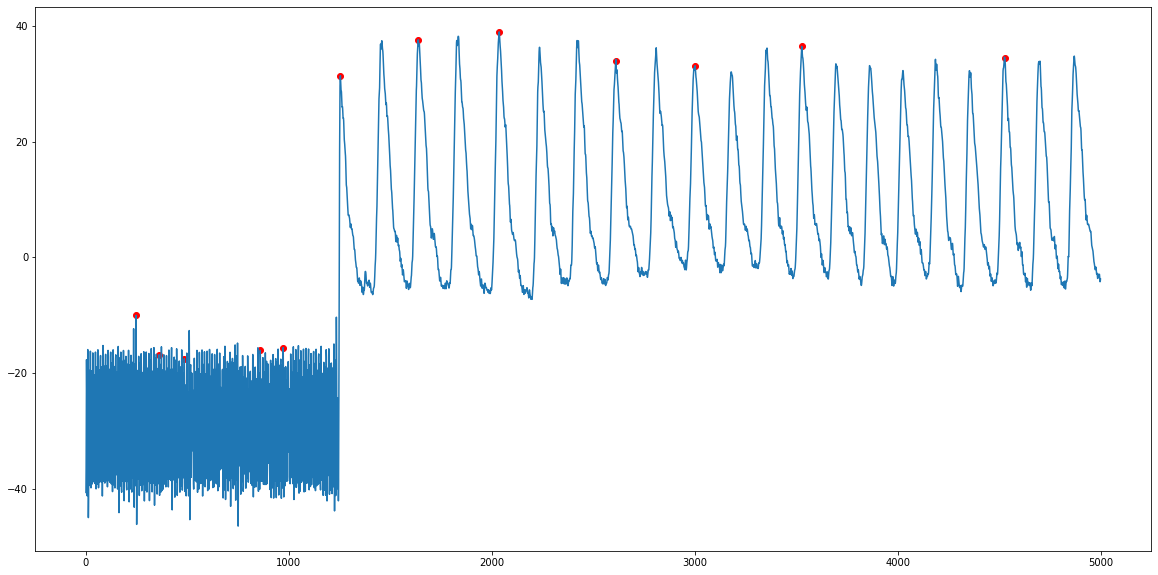

In [95]:
ab=cd[2362,0:1,:]
abb=ab[0]
abb.shape
plt.figure(figsize=(20,10))
plt.plot(abb)
#plt.figure(figsize=(20,10))
plt.scatter(peaks, abb[peaks], c='r')

In [106]:
cd=np.load('dataset/preprocess2/input3-2/x_test_pacu.npz')['arr_0']
cd.shape

(10965, 2, 5000)

In [105]:
len(peaks)

26

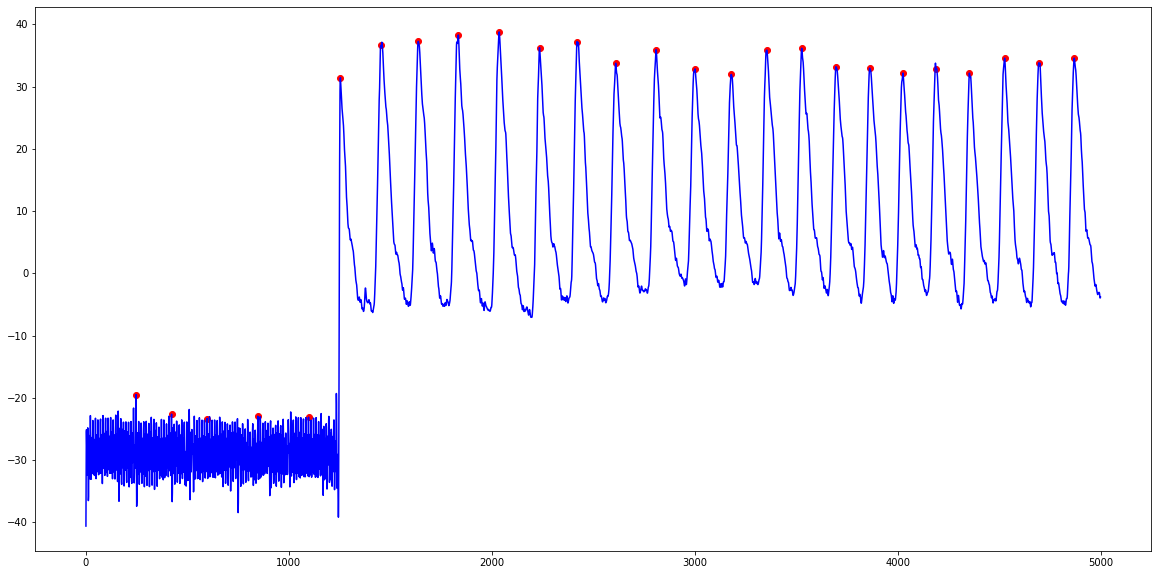

In [102]:
import arr
exs = x_test_ecg[9710,:1000]
ins = x_test_ecg[13327,:,0]
plt.figure(figsize=(20,10))
plt.plot(ins, c='b')

_, peaks = np.array(arr.detect_peaks(ins,250)).flatten()
plt.scatter(peaks, ins[peaks], c='r')

In [58]:
import pandas as pd
print(y_pred)
npy = np.array(y_pred)
print(np.mean(npy))
dics = {'bin':y_test_bin,'y_pred':y_pred}
histo = pd.DataFrame(dics)
histo.sort_values(by=['y_pred'],ascending=False, inplace=True)
histo.reset_index(inplace=True)
print(histo.loc[13700:])
#histo.loc[0:50].to_csv('dirtyECG.csv')
#print(histo)

[0.49037892 0.6439639  0.6888769  ... 0.32350346 0.27466705 0.26849708]
0.5208487
       index    bin    y_pred
13700  11431  False  0.000331
13701  11287  False  0.000321
13702  12672  False  0.000311
13703  11437  False  0.000303
13704  12864  False  0.000302
13705  11438  False  0.000256
13706  12599  False  0.000250
13707  11436  False  0.000247
13708  12845  False  0.000243
13709  12891  False  0.000230
13710  12892  False  0.000222
13711  12893  False  0.000208
13712  12890  False  0.000204
13713  11601  False  0.000196
13714  12889  False  0.000185
13715  11607  False  0.000166
13716  11602  False  0.000162
13717  12844  False  0.000162
13718  12671  False  0.000150
13719  12598  False  0.000133
13720  11604  False  0.000129
13721  12597  False  0.000126
13722  12888  False  0.000125
13723  12674  False  0.000119
13724  11603  False  0.000118
13725  12596  False  0.000116
13726  11606  False  0.000115
13727  12673  False  0.000113
13728  12595  False  0.000111
13729  11605  Fals

In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError : #, msg
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

(5000,)
(5000,)


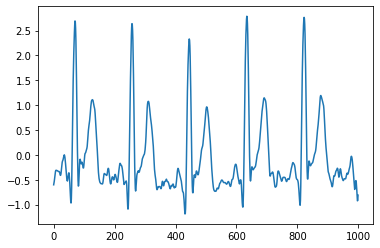

In [8]:
import matplotlib.pyplot as plt
a=x_test_ecg[6193,:].flatten()
sav = savitzky_golay(a, 25, 3, deriv=0, rate=1)
#plt.plot(a[:1000])
plt.plot(sav[:1000])
print(a.shape)
print(sav.shape)

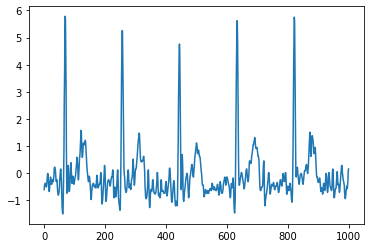

In [21]:
#Butterworth filter
from scipy.signal import butter, lfilter

def butter_bandpass(fl, fh, srate, order=5):
    nyq = 0.5 *srate
    low = fl /nyq
    high = fh / nyq
    b, a = butter(order,[low,high],btype='band')
    return b, a

def butter_bandpass_filter(data,fl,fh,srate,order=5):
    b,a=butter_bandpass(fl,fh,srate,order=order)
    y= lfilter(b,a,data)
    return y

d= butter_bandpass_filter(a,8,20,250)
plt.plot(a[:1000])
#plt.plot(d[:1000])

5000
(8196,)


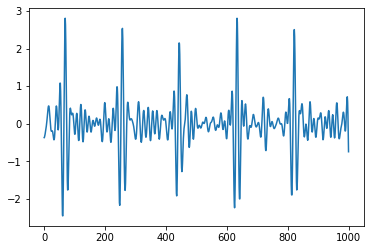

In [9]:
#Bandpass filter
import arr
import pandas as pd
import matplotlib.pyplot as plt

a=x_test_ecg[6193,:].flatten()
#plt.plot(a[:1000])
#print(a)
print(len(a))
c=np.fft.fft(a, 8196)
#print(c)
print(c.shape)
b=arr.band_pass(a,250,8,20)
plt.plot(b[:1000])

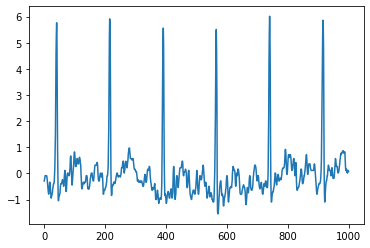

In [103]:
a=x_test_ecg[5061,:1000]
plt.plot(a)

## Model Evaluation

test set accuracy:0.69
test set auroc: 0.7401865194863592


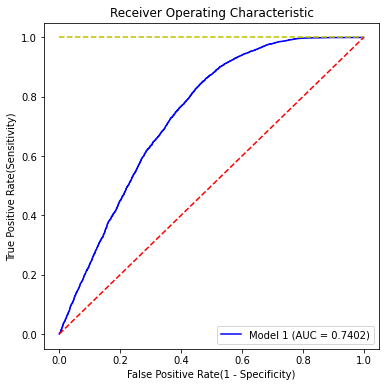

In [41]:
from sklearn.metrics import roc_curve, auc, r2_score
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

### Classification
# Model Accuracy of test set
model_y = y_pred>=0.5
acc_val = np.mean(model_y==y_test_bin)
print('test set accuracy:{:.2f}'.format(acc_val))


# Model AUROC
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('test set auroc:', roc_auc)

# Model R_square
#print('test set R2:', r2_score(y_test, y_pred*9))


# Adding evaluation results to file name
# classification
#os.rename(save_path, save_path+'_auc{:.4f}_acc{:.4f}'.format(roc_auc,np.mean(model_y==y_test_bin)))
os.rename(save_path,rootdir+'auc{:.4f}_acc{:.4f}'.format(roc_auc,acc_val)+mdir)
# regression
#os.rename(save_path, rootdir+'auc{:.4f}_acc{:.2f}_'.format(roc_auc,acc_val)+mdir)


# plotting roc
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate(1 - Specificity)")
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()

## Model history plot
- training curve

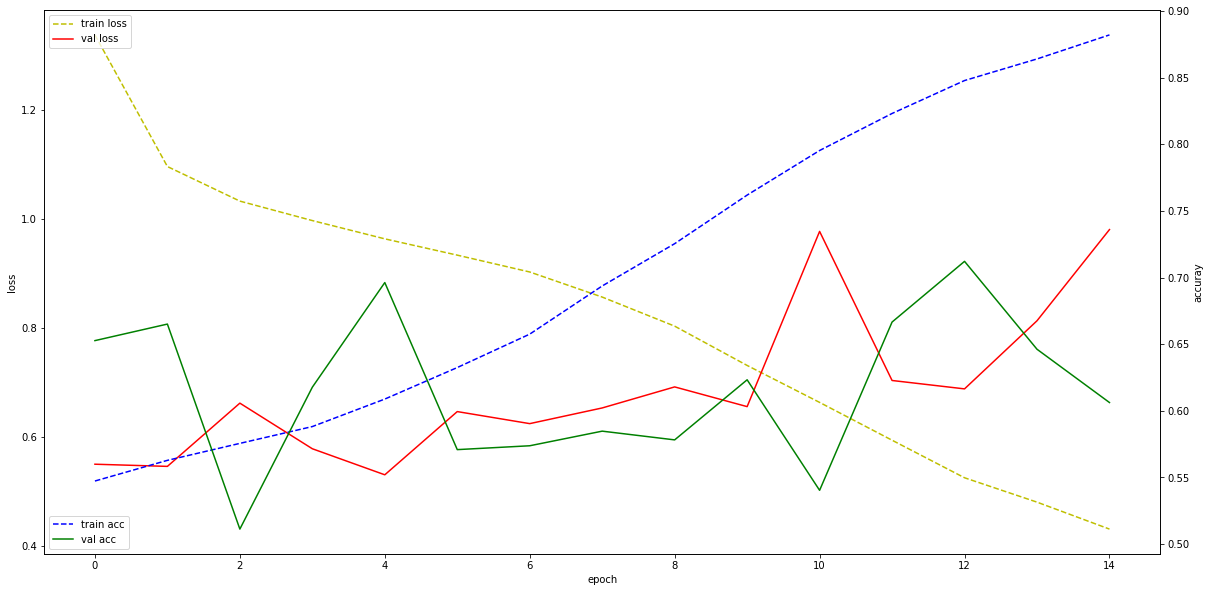

In [126]:
# model auroc 0.719짜리
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
#acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
acc_ax.plot(hist.history['acc'], 'b', linestyle='dashed',label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylim(0.2,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
test_result = model.evaluate(x=x_test, y=y_test_bin, batch_size=512, verbose=1, sample_weight=None, steps=None, callbacks=None)

## Model summary

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5000, 64)          640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5000, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2500, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2500, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2500, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2500, 64)          2

## Model ROC plot

test set auroc: 0.7829190433077462


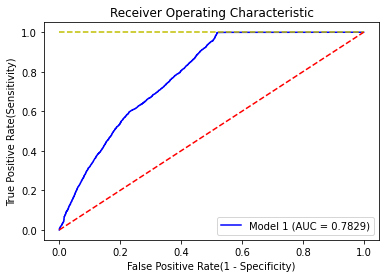

In [8]:
# Model Accuracy of test set
#print('test set accuracy:{:.2f}'.format(np.mean(y_pred>0.5==y_test_bin)))

# Model AUROC
from sklearn.metrics import roc_curve ,auc
from numpy import interp
#pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(solver='liblinear', penalty='12', random_state=1, C=100.0))

#cv = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(x_))

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('test set auroc:', roc_auc)

plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate(1 - Specificity)")
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()